# **Programa de Pós-graduação em Engenharia Elétrica e Computação (PPGEEC/UFC)**

## Tema: ``Otimização dos Hiperparâmetros de uma Rede Neural Convolucional Híbrida Utilizando Algoritmos Genéticos para Classificação de Defeitos em Imagens Eletroluminescentes de Células Fotovoltaicas``.

### **Divisão do Projeto:**

- **Seção 1** - Importação das Bibliotecas e Acesso à Base de Dados das Imagens; (**``Etapa finalizada!!``**) ✅

- **Seção 2** - Acesso e manipulação de Dados e Imagens (**``Etapa finalizada!!``**) ✅

- **Seção 3** - Implementação da CNN do tipo VGG16 pré-treinada com ImageNet; (**``Etapa finalizada!!``**) ✅

- **Seção 4** - Implementação da Máquina de Vetor de Suporte para classificação dos defeitos; (**``Etapa finalizada!!``**) ✅

- **Seção 5** - Análise dos resultados. (**``Etapa finalizada!!``**) ✅


## **Seção 1. - Importação das Bibliotecas e Acesso à Base de Dados de Imagens** (**``Etapa finalizada!!``**) ✅
---
Nesta Seção são realizadas as importações da bibliotecas para manipulação das imagens, assim como para acesso à base de dados diretamente pelo GDrive.

#### Bibliotecas necessárias para a abertura da base de dados e ligação do Google Drive com o Colab

In [ ]:
import glob
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Bibliotecas necessárias para a manipulação de dados, vetores, strings, plotagem de imagens, etc.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import random
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### Bibliotecas necessárias para importação da CNN e SVM

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
import tensorflow as tf


#### Bibliotecas necessárias para treinamento do modelo e obtenção das métricas de avaliação:


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


## **Seção 2. - Acesso e manipulação de Dados e Imagens (``Etapa finalizada!!``**) ✅


### **Seção 2.1 - Acesso à Base de Dados**

In [ ]:
# Realiza a cópia da base de dados com 2.624 imagens já com a técnica CLAHE aplicada.

!cp -r /content/drive/MyDrive/__ppgeec_mestrado/_dissertação/_base_de_dados/data_monocristalino /content/dataset

print("Operação finalizada!!")

Operação finalizada!!


In [ ]:
# Realiza a cópia do arquivo contendo o rótulo das imagens para a pasta dataset
!cp -r /content/drive/MyDrive/__ppgeec_mestrado/_dissertação/_base_de_dados/labels_data_monocristalino.csv /content/dataset

print('Operação finalizada!!')

Operação finalizada!!


### **Seção 2.2 - Acesso as imagens e seus respectivos rótulos.**

In [ ]:
images = '/content/dataset'

# Carregar o arquivo CSV
labels = pd.read_csv('/content/dataset/labels_data_monocristalino.csv', sep=';')

# Verificar os nomes das colunas
print(labels.columns)

# Supondo que a coluna original esteja corretamente identificada
if 'image;prob_defect;type_cell' in labels.columns:
    # Dividir a coluna única em três colunas
    labels[['image', 'prob_defect', 'type_cell']] = labels['image;prob_defect;type_cell'].str.split(';', expand=True)

    # Excluir a coluna original
    labels = labels.drop(columns=['image;prob_defect;type_cell'])
else:
    print("Coluna 'image;prob_defect;type_cell' não encontrada.")

# Verificar o resultado
print(labels.head())

print('Operação finalizada!!')

Index(['image', 'prob_defect', 'type_cell'], dtype='object')
Coluna 'image;prob_defect;type_cell' não encontrada.
      image  prob_defect type_cell
0  0001.png            1      mono
1  0002.png            1      mono
2  0003.png            1      mono
3  0004.png            0      mono
4  0005.png            1      mono
Operação finalizada!!


In [ ]:
# Retirando coluna chamada Unnamed
labels = labels.drop(columns=['Unnamed: 3'])

# Substituindo os valores dos rótulos 0.0 e 1.0 por números inteiros:
labels['prob_defect'] = labels['prob_defect'].replace({"1,0 ": 1, "0,0 ": 0})

print('Operação finalizada!!')

In [ ]:
labels

,image,prob_defect,type_cell
0,0001.png,1,mono
1,0002.png,1,mono
2,0003.png,1,mono
3,0004.png,0,mono
4,0005.png,1,mono
...,...,...,...
673,2436.png,0,mono
674,2437.png,1,mono
675,2441.png,0,mono
676,2442.png,0,mono


In [ ]:
# Verificar os nomes das colunas do CSV
print("Colunas disponíveis no CSV:", labels.columns)

Colunas disponíveis no CSV: Index(['image', 'prob_defect', 'type_cell'], dtype='object')


### **Seção 2.3 - Redimensionando as imagens para 224 $\times$ 224**
---

In [ ]:
# Cria o diretório para armazenar as imagens CLAHE reduzidas
output_dir = '/content/dataset_reduced'
os.makedirs(output_dir, exist_ok = True)

# Diretório onde as imagens originais estão localizadas
diretorio_originais = images

# Diretório onde você deseja salvar as imagens redimensionadas
diretorio_redimensionadas = "/content/dataset_reduced"

# Certifique-se de que o diretório de saída existe
if not os.path.exists(diretorio_redimensionadas):
    os.makedirs(diretorio_redimensionadas)

# Tamanho de destino para redimensionamento (224 x 224 pixels para VGG16)
target_size = (224, 224)

# Lista todos os arquivos no diretório de originais
arquivos = os.listdir(diretorio_originais)

# Itera sobre os arquivos e redimensiona cada imagem
for arquivo in arquivos:
    # Verifica se o arquivo tem uma extensão de imagem (por exemplo, .jpg, .jpeg, .png, .gif, .bmp)
    if arquivo.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
        # Caminho completo do arquivo de entrada (original)
        caminho_originais = os.path.join(diretorio_originais, arquivo)

        # Carrega a imagem original
        imagem_original = cv2.imread(caminho_originais)

        # Redimensiona a imagem para o tamanho de destino
        imagem_redimensionada = cv2.resize(imagem_original, target_size)

        # Caminho completo do arquivo de saída (redimensionado)
        caminho_redimensionadas = os.path.join(diretorio_redimensionadas, arquivo)

        # Salva a imagem redimensionada no diretório de saída
        cv2.imwrite(caminho_redimensionadas, imagem_redimensionada)

print("Redimensionamento concluído. As imagens foram salvas em:", diretorio_redimensionadas)

Redimensionamento concluído. As imagens foram salvas em: /content/dataset_reduced


## **Seção 3. - Implementação da CNN do tipo VGG16 pré-treinada com ImageNet** (**``Etapa finalizada!!``**) ✅

### **Seção 3.1 - Carregando as imagens da base de dados**

In [ ]:
# Função para carregar e pré-processar as imagens
def load_and_preprocess_image(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    return image

# Carregar e pré-processar todas as imagens
image_paths = labels['image'].apply(lambda x: os.path.join('/content/dataset_reduced', x))
images = np.array([load_and_preprocess_image(img_path) for img_path in image_paths])
labels = labels['prob_defect'].values

### **Seção 3.2 - Separando o conjunto de Treinamento e Teste do Modelo VGG16 e Carregando o modelo Pré-treinado**
---
Nesta etapa serão as imagens serão dividias em conjuntos de treinamento e teste, após isso o modelo VGG16 será exportado onde seus pesos serão obtidos através de um pré-treinamento coma base de dados ``ImageNet``. Por fim, adicionaremos uma camada de _Flattering_ e realizaremos a extração de características que será utilizada no processo de classificação pela ``sVM``[texto do link](https://)

In [ ]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state = 42)

In [ ]:
# Carregar o modelo VGG-16 pré-treinado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar as camadas do modelo base
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Adicionar a camada de flattening
x = base_model.output
x = tf.keras.layers.Flatten()(x)
model = Model(inputs=base_model.input, outputs=x)


In [ ]:
# Extrair características das imagens de treino e teste
X_train_features = model.predict(X_train)
X_test_features = model.predict(X_test)

5/5 [==============================] - 1s 125ms/step


## **Seção 4. - Implementação da Máquina de Vetor de Suporte para classificação dos defeitos; (``Etapa finalizada!!``)** ✅

### **Seção 4.1 - Busca otimizada dos hiperparâmetros da ``SVM``**

In [ ]:
# Definir o classificador SVM e os hiperparâmetros para a busca
svm = SVC()
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly']
}

In [ ]:
# Realizar a busca de hiperparâmetros com validação cruzada
grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_features, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=2)

In [ ]:
# Obter os melhores parâmetros
best_svm = grid_search.best_estimator_
print(f'Melhores parâmetros da SVM: {grid_search.best_params_}')

### **Seção 4.2 - Definição dos parâmetros da SVM de acordo com o resultado obtido pelo ``GridSearch``**
---

In [ ]:
# Definir o classificador SVM com os melhores parâmetros
svm = SVC(C = 100, gamma = 'scale', kernel = 'rbf')

In [ ]:
# Treinar o modelo SVM com os dados de treino
svm.fit(X_train_features, y_train)  # Add this line to train the model

# Fazer previsões no conjunto de teste
y_pred = svm.predict(X_test_features)

In [ ]:
# Fazer previsões no conjunto de teste
y_pred = svm.predict(X_test_features)

## **Seção 5. - Análise dos Resultados (``Etapa finalizada!!``)** ✅

### **Seção 5.1 - Obtendo as métricas ``Acurácia``, ``Índice Kappa``, ``Precisão``, ``Sensibilidade`` e ``f1-score``**

In [ ]:
# Calcular as métricas
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
kappa = cohen_kappa_score(y_test, y_pred)

In [ ]:
# Resultados das métricas obtidas no conjunto de teste.
print('Métricas obtidas no teste do modelo')
print(f'Acurácia: {accuracy:.4f}')
print(f'Índice kappa: {kappa:.4f}')
print(f'Precisão: {report["weighted avg"]["precision"]:.4f}')
print(f'Sensibilidade (Recall): {report["weighted avg"]["recall"]:.4f}')
print(f'F1-score: {report["weighted avg"]["f1-score"]:.4f}')

Métricas obtidas no teste do modelo
Acurácia: 0.8676
Índice kappa: 0.7304
Precisão: 0.8715
Sensibilidade (Recall): 0.8676
F1-score: 0.8665


### **Seção 5.2 - Plotagem da matriz de confusão (Confusion Matrix)**

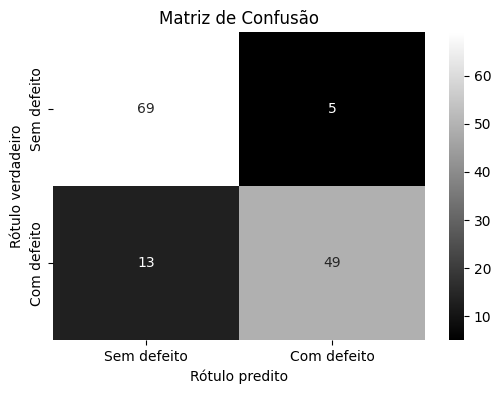

In [ ]:
# Função para plotar a matriz de confusão
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='gray', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Rótulo predito')
    plt.ylabel('Rótulo verdadeiro')
    plt.title('Matriz de Confusão')
    plt.show()

class_names = ['Sem defeito', 'Com defeito']  # Replace with your actual class names

plot_confusion_matrix(conf_matrix, class_names)

In [ ]:
# Definir o número de folds
n_splits = 5

# Inicializar o StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits)

# Listas para armazenar as matrizes de confusão e as acurácias
conf_matrices = []
accuracies = []

# Loop pelos folds
for train_index, test_index in skf.split(X_train_features, y_train):
    X_train_fold, X_test_fold = X_train_features[train_index], X_train_features[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # Treinar o modelo
    svm.fit(X_train_fold, y_train_fold)

    # Fazer predições
    y_pred = svm.predict(X_test_fold)

    # Calcular a matriz de confusão
    conf_matrix = confusion_matrix(y_test_fold, y_pred)
    conf_matrices.append(conf_matrix)

    # Calcular a acurácia
    accuracy = np.mean(y_pred == y_test_fold)
    accuracies.append(accuracy)

# Plotar as matrizes de confusão
fig, axes = plt.subplots(1, n_splits, figsize=(15, 5))

for i, conf_matrix in enumerate(conf_matrices):
    ax = axes[i]
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(f'Fold: {i+1}\nAcurácia: {accuracies[i]:.4f}')
    tick_marks = np.arange(len(np.unique(y_train)))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(np.unique(y_train))
    ax.set_yticklabels(np.unique(y_train))
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')

    # Loop sobre dados para criar as anotações
    fmt = 'd'
    thresh = conf_matrix.max() / 2.
    for j, k in np.ndindex(conf_matrix.shape):
        ax.text(k, j, format(conf_matrix[j, k], fmt),
                ha="center", va="center",
                color="white" if conf_matrix[j, k] > thresh else "black")

fig.tight_layout()
plt.colorbar(im, ax=axes.ravel().tolist())
plt.show()

# Imprimir a acurácia média e o desvio padrão
print(f'Acurácia média: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}')


### **Seção 5.3 - Acurácia média com validação cruzada (k-fold, k = 5) e Resultados Visuais da classificação**

In [ ]:
# Calcular acurácia com desvio padrão usando validação cruzada
cross_val_scores = cross_val_score(svm, X_train_features, y_train, cv=5)
print(f'Acurácia média e desvio padrão: {cross_val_scores.mean():.4f} ± {cross_val_scores.std():.4f}')


Acurácia média e desvio padrão: 0.8951 ± 0.0131


### **Seção 5.4 - Resultados Visuais da classificação (Verdadeiros Positivos [VP] e Verdadeiros Negativos [VN])**

In [ ]:
# Função para plotar imagens de Verdadeiro Positivo e Verdadeiro Negativo
def plot_false_neg_pos(images, true_labels, pred_labels, class_names, num_images=10):
    # Encontrar índices de Falsos Negativos (FN) e Falsos Positivos (FP)
    fn_indices = np.where((true_labels == 1) & (pred_labels == 1))[0]
    fp_indices = np.where((true_labels == 0) & (pred_labels == 0))[0]

    # Selecionar um número de imagens a serem plotadas, dependendo do menor tamanho entre num_images e a quantidade de FN/FP encontrados
    num_images_fn = min(len(fn_indices), num_images // 2)
    num_images_fp = min(len(fp_indices), num_images // 2)

    # Se não houver VP ou VN suficientes, ajustar a quantidade a ser plotada
    total_images = num_images_fn + num_images_fp

    # Criar a figura para plotar
    plt.figure(figsize=(15, 8))

    # Plotar Verdadeiros Positivos:
    for i in range(num_images_fn):
        ax = plt.subplot(2, total_images // 2, i + 1)
        plt.imshow(images[fn_indices[i]].astype('uint8'))
        true_label = class_names[true_labels[fn_indices[i]]]
        pred_label = class_names[pred_labels[fn_indices[i]]]
        plt.title(f'True: {true_label}\nPred:: {pred_label}')
        plt.axis('off')

    # Plotar Verdadeiros Negativos:
    for i in range(num_images_fp):
        ax = plt.subplot(2, total_images // 2, num_images_fn + i + 1)
        plt.imshow(images[fp_indices[i]].astype('uint8'))
        true_label = class_names[true_labels[fp_indices[i]]]
        pred_label = class_names[pred_labels[fp_indices[i]]]
        plt.title(f'True: {true_label}\nPred:: {pred_label}')
        plt.axis('off')

    plt.show()

# Definir nomes das classes
class_names = ['0', '1']

# Chamar a função para plotar imagens de Falsos Negativos e Falsos Positivos
plot_false_neg_pos(X_test, y_test, y_pred, class_names, num_images=20)


ValueError: operands could not be broadcast together with shapes (68,) (122,) 

### **Seção 5.5 - Resultados Visuais da classificação (Falsos Positivos e Falsos Negativos)**

In [ ]:
# Função para plotar imagens de Falso Negativo e Falso Positivo
def plot_false_neg_pos(images, true_labels, pred_labels, class_names, num_images=10):
    # Encontrar índices de Falsos Negativos (FN) e Falsos Positivos (FP)
    fn_indices = np.where((true_labels == 1) & (pred_labels == 0))[0]
    fp_indices = np.where((true_labels == 0) & (pred_labels == 1))[0]

    # Selecionar um número de imagens a serem plotadas, dependendo do menor tamanho entre num_images e a quantidade de FN/FP encontrados
    num_images_fn = min(len(fn_indices), num_images // 2)
    num_images_fp = min(len(fp_indices), num_images // 2)

    # Se não houver FN ou FP suficientes, ajustar a quantidade a ser plotada
    total_images = num_images_fn + num_images_fp

    # Criar a figura para plotar
    plt.figure(figsize=(15, 8))

    # Plotar Falsos Negativos
    for i in range(num_images_fn):
        ax = plt.subplot(2, total_images // 2, i + 1)
        plt.imshow(images[fn_indices[i]].astype('uint8'))
        true_label = class_names[true_labels[fn_indices[i]]]
        pred_label = class_names[pred_labels[fn_indices[i]]]
        plt.title(f'True: {true_label}\n Pred: {pred_label}')
        plt.axis('off')

    # Plotar Falsos Positivos
    for i in range(num_images_fp):
        ax = plt.subplot(2, total_images // 2, num_images_fn + i + 1)
        plt.imshow(images[fp_indices[i]].astype('uint8'))
        true_label = class_names[true_labels[fp_indices[i]]]
        pred_label = class_names[pred_labels[fp_indices[i]]]
        plt.title(f'True: {true_label}\n Pred: {pred_label}')
        plt.axis('off')

    plt.show()

# Definir nomes das classes
class_names = ['0', '1']

# Chamar a função para plotar imagens de Falsos Negativos e Falsos Positivos
plot_false_neg_pos(X_test, y_test, y_pred, class_names, num_images=20)


ValueError: operands could not be broadcast together with shapes (68,) (122,) 